In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Chargement des données

Ci-dessous la déclaration de la fonction load_data avec 3 paramètres:
 - isTest: permet d'obtenir les images dans le fichiers de test ou de train
 - randomize: Change l'ordre des images et labels en gardant la valeur associative
 - booleanOutput: Permet d'avoir soit 2 labels, soit 3 labels différents dans notre cas

La fonction va read avec la fonction d'openCV **imread** chaque image qui se trouve dans les dossiers
se trouvant dans le dossier *../chest_Xray/(test ou train)/*, ainsi il va récupéré toutes les images dans
le dossier NORMAL et PNEUMONIA.

On utilise le paramètre d'openCV pour lire l'image en nuance de gris, comme c'est une radio.
Une fois l'image lu, on resize l'image pour quelles aient toute la même taille (ici : 400x400)

Ensuite on flatten l'image ce qui revient à transformer un tableau en 2D vers un tableau en une dimension

Et pour chaque image qu'on ajoute à notre liste, on ajoute un libelle (0, 1 (ou 2 si booleanOutput)) 1 étant la valeur pour la pneumonie

In [5]:
def load_data(isTest = False, randomize = False, booleanOutput = False):
    images = []
    labels = []
    default = "../chest_Xray/"
    if isTest:
        default = default + "test/"
    else:
        default = default + "train/"

    for typee in ["NORMAL", "PNEUMONIA"]:
        pathType = default + typee + "/"
        for file in os.listdir(pathType):
            completePath = pathType + file
            img = cv2.imread(completePath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (128,128))
            imgArr = np.array(img)
            pixels = img.flatten()
            images.append(pixels)
            if typee == "PNEUMONIA":
                if 'virus' in file and not booleanOutput:
                    labels.append(2)
                else:
                    labels.append(1)
            else:
                labels.append(0)

    images = np.array(images)
    labels = np.array(labels)
    if randomize:      
        indices = np.random.permutation(images.shape[0])
        images = images[indices]
        labels = labels[indices]
    return (images, labels)


        
    

# Utilisation de Scikit-learn

J'ai créée une classe qui prends en paramètres le nombre de n_neighbors et les données d'entraînements pour l'algorithme KNN
Lors de l'init de la classe il crée une instance de KNeighborsClassifier venant de Scikit-learn avec le nombre de n_neighbors demandés

La fonction score permet d'obtenir le taux de prédiction correcte avec un échantillon de données passer en paramètres (de préférence ne pas utiliser des données d'entrainement)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

class knn:
    def __init__(self, neighbors, train):
        self.knn = KNeighborsClassifier(n_neighbors = neighbors)
        self.knn.fit(train[0], train[1])

    def score(self, test):
        return self.knn.score(test[0], test[1])
        
nb_repetition = 20

# Test en sortie binaire (pneumonia ou pas pneumonia ?)

Les tests ci-dessous vont tester l'algorithme KNN avec un nombre n_neighbors de 1 à 20

## Chargement des données

In [7]:
bOut = True

images_train_rand, labels_train_rand = load_data(randomize= True, booleanOutput = bOut)
images_train_ord, labels_train_ord = load_data(booleanOutput = bOut)
images_test, labels_test = load_data(True, booleanOutput = bOut)

## Test données dans l'ordre

In [8]:
score_ord = []
for i in range(nb_repetition + 1):
    if i == 0:
        continue
    tmpScore = knn(i, (images_train_ord, labels_train_ord)).score((images_test, labels_test))
    score_ord.append(tmpScore)

## Test données dans le désordre

In [9]:
score = []
for i in range(nb_repetition + 1):
    if i == 0:
        continue
    tmpScore = knn(i, (images_train_rand, labels_train_rand)).score((images_test, labels_test))
    score.append(tmpScore)

## Affichage des résultats

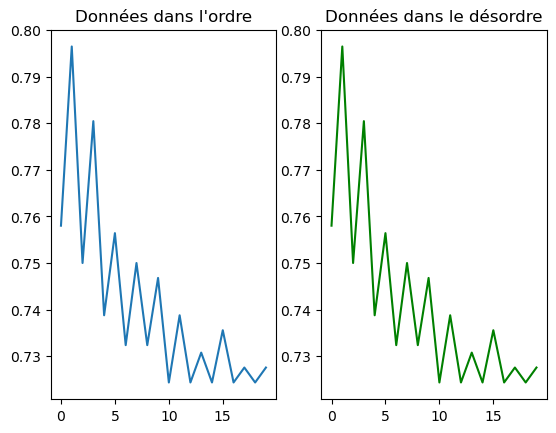

In [10]:
fig, ax = plt.subplots(ncols = 2)

ax[0].plot(score)
ax[0].set_title("Données dans l'ordre")
ax[1].plot(score_ord, color="green")
ax[1].set_title("Données dans le désordre")
plt.show()

# Test en sortie trinaire (pneumonie virale, pneumonie bactérienne ou pas de pneumonie ?)

Les tests ci-dessous vont tester l'algorithme KNN avec un nombre n_neighbors de 1 à 20

## Chargement des données

In [11]:
bOut = False

images_train_rand, labels_train_rand = load_data(randomize= True, booleanOutput = bOut)
images_train_ord, labels_train_ord = load_data(booleanOutput = bOut)
images_test, labels_test = load_data(True, booleanOutput = bOut)

## Test données dans l'ordre

In [12]:
score_ord = []
for i in range(nb_repetition + 1):
    if i == 0:
        continue
    tmpScore = knn(i, (images_train_ord, labels_train_ord)).score((images_test, labels_test))
    score_ord.append(tmpScore)

## Test données dans le désordre

In [13]:
score = []
for i in range(nb_repetition + 1):
    if i == 0:
        continue
    tmpScore = knn(i, (images_train_rand, labels_train_rand)).score((images_test, labels_test))
    score.append(tmpScore)

## Affichage des résultats

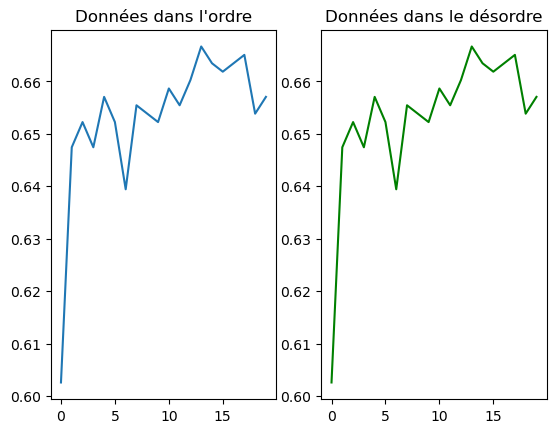

In [14]:
fig, ax = plt.subplots(ncols = 2)

ax[0].plot(score)
ax[0].set_title("Données dans l'ordre")
ax[1].plot(score_ord, color="green")
ax[1].set_title("Données dans le désordre")
plt.show()

# Conclusion

Pour KNeighbors dans notre cas l'ordre des données n'influent pas les résultats.

Dans le test avec un résultat binaire on remarque le l'algorithme performe le mieux quand le nombre de neighbors est un multiplie de 2, même si au vu du graphique, on peut dire que c'est 2 la meilleur valeur pour cette algorithme.

Sans traitement d'image avec juste le resize + flatten de l'image on obtiens presque 80% de précision en résultat binaire avec 2 en neighbors.


On remarque que en ajoutant la possibilité de faire la différence entre pneumonie virale et bactérienne que le score de précision chut de pas mal, avec le meilleur neighbors que j'ai trouvé, j'obtiens à peine 67% de précision ce qui est faible.

